<a href="https://colab.research.google.com/github/wafa-b/Introduction-to-Deep-Learning-with-PyTorch/blob/master/Style-Transfer/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer with Deep Neural Networks

we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

Style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv_1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv_2_1 is the first convolutional layer in the second stack. The deepest convolutional layer in the network is conv_5_4.

### Separating Style and Content
Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir("/content/drive/My Drive/")

In [4]:
!unzip images.zip

Archive:  images.zip
replace images/ben_passmore.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
!pip install Pillow
!pip install PIL
!pip install image
import PIL

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [0]:
#Import Libraries
import torch
import numpy as np
import requests
import torch.optim as optim
from  torchvision import transforms,models
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

### Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

We only need the `features` portion, which we're going to load in and "freeze" the weights.

In [7]:
#Get features oprtion of VGG19
vgg=models.vgg19(pretrained=True).features
#Freeze all VGG paramwters since we are onle optimizing target image
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:54<00:00, 10.5MB/s]


In [8]:
#Move model to GPU , If available
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load in Content and Style Images

We've provided a helper function for loading in any type and size of image. 
The `load_image` function also converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [0]:
def load_image(img_path,max_size=400,shape=None):
    if "http" in img_path:
        response=requests.get(img_path)
        image=Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image=Image.open(img_path).convert("RGB")
        
    #Large images will slow down processing
    if max(image.size)>max_size:
        size=max(image.size)
    else:
        size=max(image.size)
    
    if shape is not None:
        size=shape
        
    in_transform=transforms.Compose([transforms.Resize(size),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485,0.456,0.406),
                                                        (0.229,0.224,0.225))])
    #Discard transparent,alpha channel and & batch dimension
    image=in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

Now We're loading in images by file name and forcing the style image to be the same size as the content image

In [0]:
#Load content image
content=load_image('images/octopus.jpg').to(device)
#Load style image & Resize it to match content
style=load_image('images/hockney.jpg',shape=content.shape[-2:]).to(device)

In [0]:
#Helper function to un-normalizing image & converting it form Tensor image to NumPy image for display
def image_convert(tensor):
    image=tensor.to("cpu").clone().detach()
    image=image.numpy().squeeze()
    image=image.transpose(1,2,0)
    image=image*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
    image=image.clip(0,1)
    
    return image

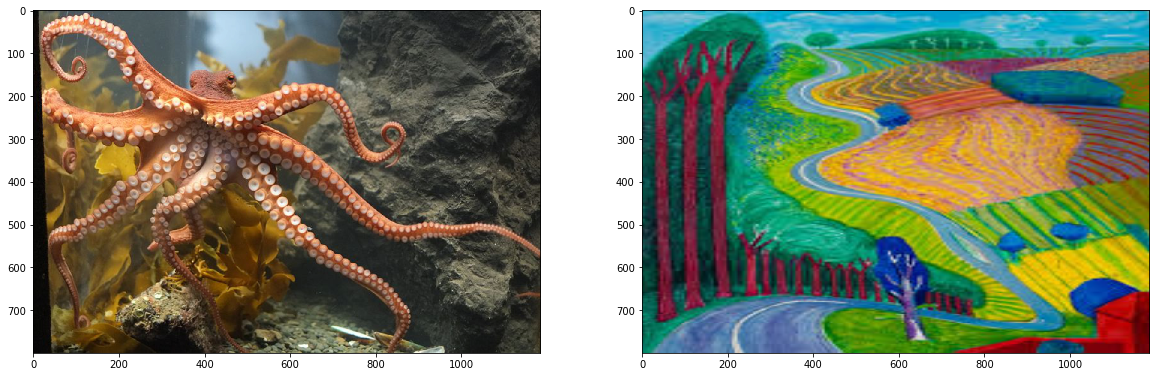

In [12]:
#Display imagesd
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
# display content image & style image side-by-side
ax1.imshow(image_convert(content))
ax2.imshow(image_convert(style))

### VGG19 Layers
To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer

In [13]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and Style Features

### TODO: complete the mapping of layer names to the names found in the paper for the _content representation_ and the _style representation_.

In [0]:
def get_features(image,model,layers=None):
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers={'0':'conv1_1',
               '5':'conv2_1',
               '10':'conv3_1',
               '19':'conv4_1',
               '21':'conv4_2',
               '28':'conv5_1'}
    features={}
    x=image
    #model._modules is a dictionary holding each module in the model
    for name,layer in model._modules.items():
        x=layer(x)
        if name in layers:
            features[layers[name]]=x
            
    return features

### Gram Matrix 

The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size()`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose 

*Note: You can multiply two matrices using `torch.mm(matrix1, matrix2)`.*

### TODO: Complete the `gram_matrix` function.

In [0]:
def gram_matrix(tensor):
    #Get the batch_size, depth, height, and width of the Tensor
    _,d,h,w=tensor.size()
    #Reshape it, so we're multiplying the features for each channel
    tensor=tensor.view(d,h*w)
    #Calculate the gram matrix
    gram=torch.mm(tensor,tensor.t())
    
    return gram

### Putting it all Together

Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [0]:
#Get content and style features only once before training
content_features=get_features(content,vgg)
style_features=get_features(style,vgg)

#Calculate gram matrices for each layer of our style representation
style_grams={layer:gram_matrix(style_features[layer]) for layer in style_features}

#Create a third "target" image and prep it for change
#It is a good idea to start off with the target as a copy of our *content* image
#Then iteratively change its style
target=content.clone().requires_grad_(True).to(device)

## Loss and Weights

### Individual Layer Style Weights

Below, you are given the option to weight the style representation at each relevant layer. It's suggested that you use a range between 0-1 to weight these layers. By weighting earlier layers (`conv1_1` and `conv2_1`) more, you can expect to get _larger_ style artifacts in your resulting, target image. Should you choose to weight later layers, you'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

### Content and Style Weight

Just like in the paper, we define an alpha (`content_weight`) and a beta (`style_weight`). This ratio will affect how _stylized_ your final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want.

In [0]:
#Weights for each style layer 
#Weighting earlier layers more will result in *larger* style artifacts
#Notice we are excluding `conv4_2` our content representation
style_weights={'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}
content_weight=1  # alpha
style_weight=1e6  # beta

### Updating the Target & Calculating Losses

You'll decide on a number of steps for which to update your image, this is similar to the training loop that you've seen before, only we are changing our _target_ image and nothing else about VGG19 or any other image. Therefore, the number of steps is really up to you to set! **It's recommend using at least 2000 steps for good results.** But, you may want to start out with fewer steps if you are just testing out different weight values or experimenting with different images.

Inside the iteration loop, we'll calculate the content and style losses and update your target image, accordingly.

### Content Loss

The content loss will be the mean squared difference between the target and content features at layer `conv4_2`. This can be calculated as follows: 
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

### Style Loss

The style loss is calculated in a similar way, only you have to iterate through a number of layers, specified by name in our dictionary `style_weights`. 
> We'll calculate the gram matrix for the target image, `target_gram` and style image `style_gram` at each of these layers and compare those gram matrices, calculating the `layer_style_loss`. 
> Later, We'll see that this value is normalized by the size of the layer.

### Total Loss

Finally, We'll create the total loss by adding up the style and content losses and weighting them with our specified alpha and beta!

Intermittently, we'll print out this loss; don't be alarmed if the loss is very large. It takes some time for an image's style to change and we should focus on the appearance of our target image rather than any loss value. Still, we should see that this loss decreases over some number of iterations.

### TODO: Define content, style, and total losses.

Total loss:  4225345.0
Total loss:  4225345.0


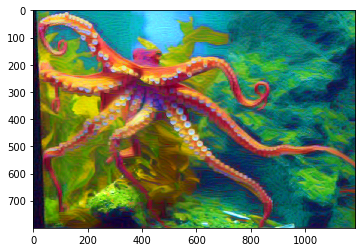

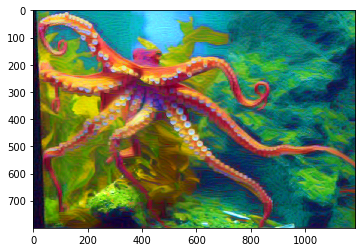

Total loss:  1177207.625
Total loss:  1177207.625


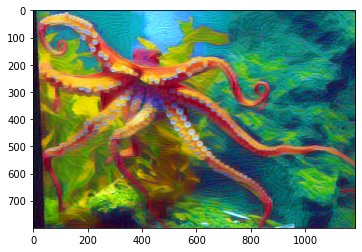

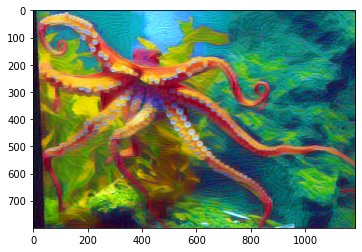

Total loss:  644912.0625
Total loss:  644912.0625


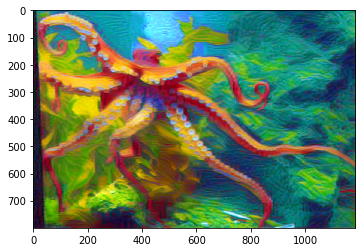

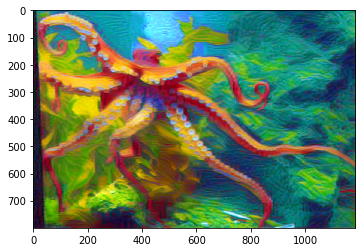

Total loss:  425753.21875
Total loss:  425753.21875


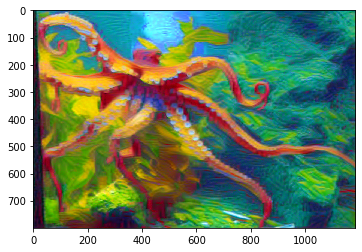

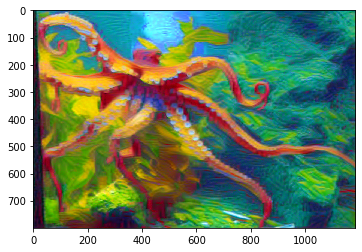

Total loss:  311314.6875
Total loss:  311314.6875


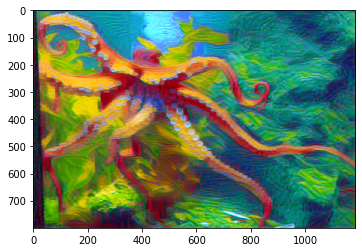

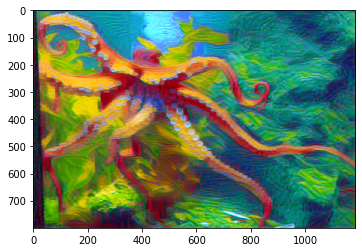

Total loss:  4225345.0


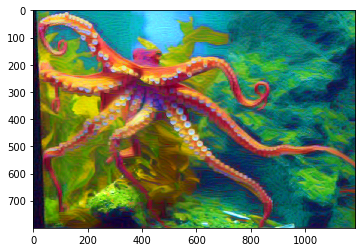

Total loss:  1177207.625


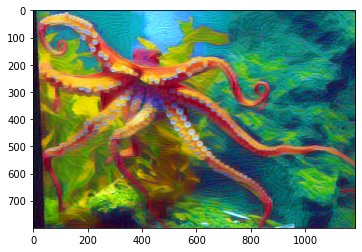

Total loss:  644912.0625


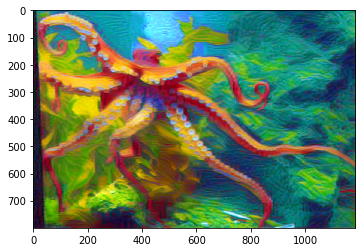

Total loss:  425753.21875


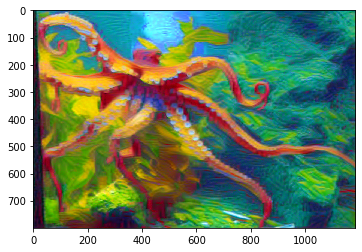

Total loss:  311314.6875


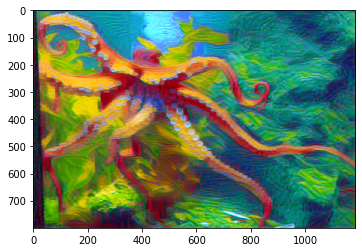

In [21]:
#To displaying the target image,intermittently
show_every=400

#Iteration hyperparameters
optimizer=optim.Adam([target],lr=0.003)
steps=2000  # decide how many iterations to update your image (5000)

for ii in range(1,steps+1):
    
    ##Get the features from your target image    
    target_features=get_features(target,vgg)
    ##Then calculate the content loss
    content_loss=torch.mean((target_features['conv4_2']-content_features['conv4_2']**2))
    
    #The style loss
    #Initialize the style loss to 0
    style_loss = 0
    #Iterate through each style layer and add to the style loss
    for layer in style_weights:
        #Get the "target" style representation for the layer
        target_feature=target_features[layer]
        _, d, h, w=target_feature.shape
        
        #Calculate target gram matrix
        target_gram=gram_matrix(target_feature)
        _,d,h,w=target_feature.shape
        
        #Get style representation
        style_gram=style_grams[layer]
        #Calculate the style loss for one layer, weighted appropriately
        layer_style_loss=style_weights[layer]*torch.mean((target_gram - style_gram)**2)

        #Add to the style loss
        style_loss+=layer_style_loss/(d*h*w)
        
        
    #Calculate total loss
    total_loss=content_weight*content_loss+style_weight*style_loss

        #Update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    #Display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(image_convert(target))
        plt.show()

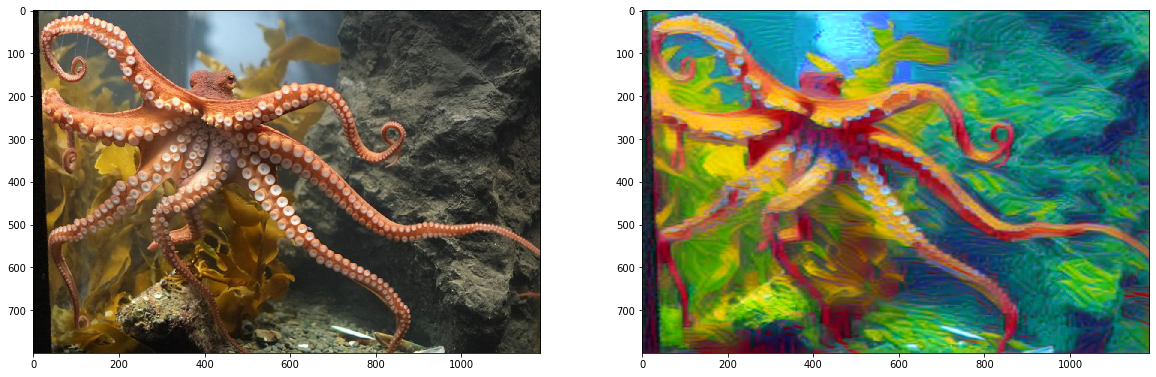

In [23]:
#Display content & final target image
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(image_convert(content))
ax2.imshow(image_convert(target))